# Event Risk

_Don’t worry about failure; you only have to be right once_ — Drew Houston

Event risk refers to the potential for a sudden and significant impact on an asset's price or a portfolio's value due to an unforeseen event. These can be company-specific or broad market events that introduce volatility and uncertainty. For example, a company missing or exceeding analysts' earnings expectations can cause sharp price movements. Other types of event risk in finance include credit defaults and downgrades, mergers and acquisitions, or monetary policy changes. We explore how **Poisson regression**, an example of a **generalized linear model (GLM)** suited for count data, can be used to model the frequency of events such as earnings misses.


In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from finds.database import SQL, RedisDB
from finds.structured import BusDay, SignalsFrame, CRSP, IBES
from finds.readers import Alfred
from secret import credentials, paths, CRSP_DATE
VERBOSE = 0
#%matplotlib qt

In [2]:
# open connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
ibes = IBES(sql, bd, verbose=VERBOSE)
LAST_DATE = CRSP_DATE

## Earnings expectations

The consensus analyst estimate for a company's quarterly earnings is derived from the average of all the analyst forecasts covering that company. The number of analysts following a particular company typically correlates with the company's size and the liquidity of its stock. Large, well-known companies often have many analysts providing coverage, resulting in a consensus estimate derived from various opinions. In contrast, smaller or less-recognized companies may have only a few analysts covering them, or none at all.

When a company reports earnings that fall below the consensus expectation, this is referred to as an *earnings miss*. On the other hand, if the company's earnings exceed the analysts' expectations, it is called an *earnings beat*.

### Standardized unexpected earnings (SUE)

To quantify earnings surprises, the Standardized Unexpected Earnings (SUE) is calculated. This is determined by subtracting the median of the analysts' estimates for a particular fiscal quarter from the company's reported earnings, then scaling it by the stock price.


In [3]:
# retrieve ibes Q1 where forecast period <= fiscal date, and keep latest
df = ibes.get_linked(dataset='statsum',
                     fields=['fpedats', 'medest', 'actual'],
                     date_field='statpers',
                     where=" fpi = '6' AND statpers <= fpedats")


In [4]:
summ = df.dropna()\
         .sort_values(['permno', 'fpedats', 'statpers'])\
         .drop_duplicates(['permno', 'fpedats'], keep='last')
summ['rebaldate'] = bd.endmo(summ['fpedats'])
summ = summ.set_index(['permno', 'statpers'])

In [5]:
# retrieve ibes price
df = ibes.get_linked(dataset='actpsum',
                     fields=['price'],
                     date_field='statpers')


In [6]:
hist = df.dropna()\
         .sort_values(['permno', 'statpers'])\
         .drop_duplicates(['permno', 'statpers'], keep='last')
hist = hist.set_index(['permno', 'statpers'])

In [7]:
# calculate sue with ibes surprise and price
summ = summ.join(hist[['price']], how='inner')
summ['sue'] = (summ['actual'] - summ['medest']).div(summ['price'])

In [8]:
# define large earnings surprises as 5% of price
START = 19841201
signals = SignalsFrame(summ.reset_index(drop=False))
rebaldates = bd.date_range(START, LAST_DATE-100, freq='quarterly')
label = 'sue'
out = []
for rebaldate in rebaldates:
    univ = crsp.get_universe(rebaldate)    # get this quarter's universe
    univ = univ[(abs(univ['prc']) >= 5.0) & (univ['decile'] < 9)]  # no small low-price
    signal = signals(label=label,
                     date=rebaldate,
                     start=bd.endqr(rebaldate, quarters=-1))\
                     .reindex(univ.index)\
                     .dropna()\
                     .reset_index()
    signal['rebaldate'] = rebaldate // 100
    signal['miss'] = signal['sue'] < -0.05   # large earnings misses
    out.append(signal.set_index('permno').join(univ['decile'], how='inner')\
               .reset_index())
out = pd.concat(out)

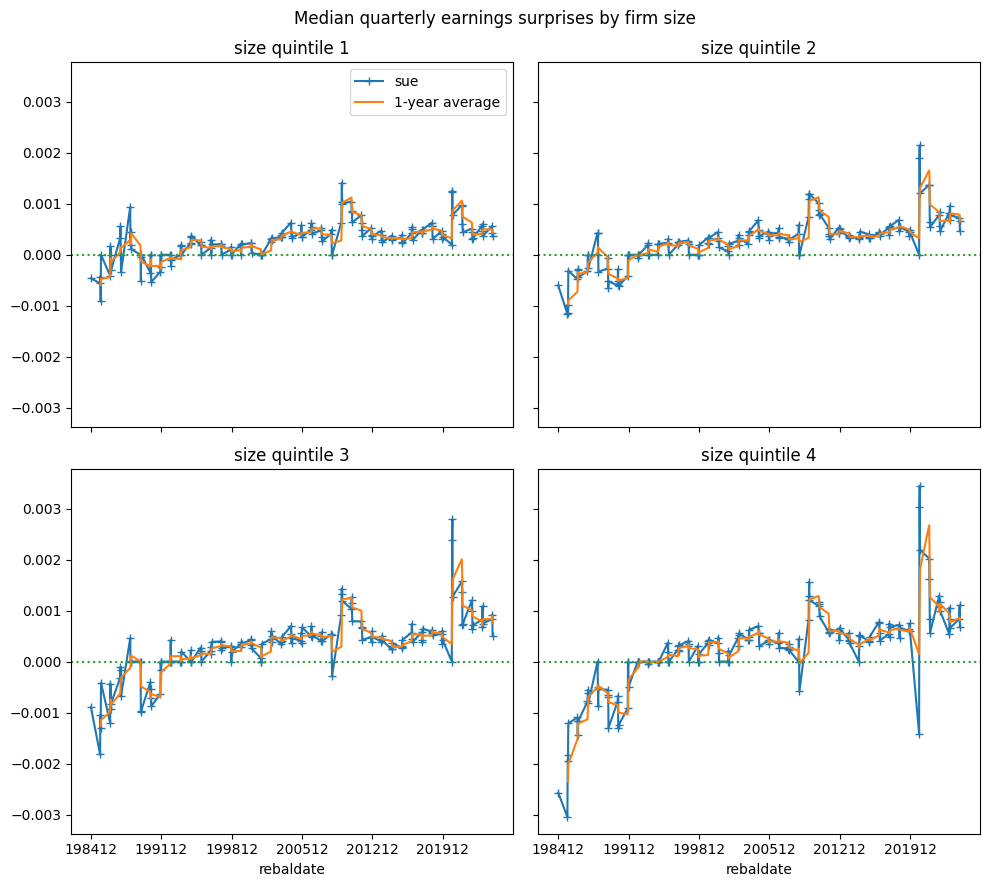

In [9]:
# median quarterly earnings surprise by firm size
fig, axes = plt.subplots(2, 2, figsize=(10, 9), sharex=True, sharey=True)
axes = axes.flatten()
for label, (ax, dec) in enumerate(zip(axes, [[1,2], [3,4], [5,6], [7,8]])):
    y = out[out['decile'].isin(dec)].groupby('rebaldate')['sue'].median()
    y.plot(ax=ax, marker='+', color="C0")
    y.rolling(4).mean().plot(ax=ax, color="C1")
    ax.set_title(f"size quintile {label+1}")
    if not label:
        ax.legend(['sue','1-year average'])
    ax.axhline(0, color='C2', ls=':')
    ax.set_xticks(y.index[::28])
    ax.minorticks_off()
plt.suptitle('Median quarterly earnings surprises by firm size')
plt.tight_layout()
plt.show()

Historically, the median earnings surprise was negative (i.e. estimates were too optimistic), especially for smaller stocks, until the early-1990s, after which the trend generally shifted to positive earnings surprises


### Earnings misses

We define earnings misses to be large negative earnings surprises exceeding 5% of stock price.

In [10]:
# count number of stocks with large earnings misses
frac = out.groupby('rebaldate')['miss'].mean().rename('frac')
count = out.groupby('rebaldate')['miss'].sum().rename('count')
exposures = out['rebaldate'].value_counts().sort_index().rename('exposures')
Y = pd.concat([exposures, frac, count], axis=1)
Y.index = Y.index.astype(str)
print("Earnings misses")
Y

Earnings misses


,exposures,frac,count
rebaldate,,,
198412,1327,0.051997,69
198503,1302,0.038402,50
198506,1384,0.040462,56
198509,1384,0.033960,47
198512,1398,0.063662,89
...,...,...,...
202309,1845,0.008672,16
202312,1812,0.009934,18
202403,1764,0.003401,6


## Poisson regression


The Poisson distribution is often used to model count data, or events that occur in a fixed period of time or space. Poisson regression models the expected count of events as a function of certain covariates. Specifically, it is expressed as:

$$
\log(E[Y | X]) = \beta X
$$

which is equivalent to:

$$
E[Y | X] = e^{\beta X}
$$

In this model, the interpretation of the coefficient $\beta$ is that an increase in $X_i$ by one unit is associated with a multiplicative change in the expected value of $Y_i$ by a factor of $e^{\beta_i}$. The variance of $Y_i$ under the Poisson model is equal to its expected value, i.e., $Var[Y_i] = E[Y_i]$. Importantly, the Poisson model ensures that the fitted values are non-negative, as it only allows for counts of zero or more.

Poisson regression can also be useful for modeling rates, where the event count is divided by some measure of exposure. For example, when modeling the number of stocks with large earnings misses each quarter, the exposure would be the total number of stocks, denoted $N$. The log of the total number of stocks, called the *offset* variable, is included in the regression equation with a coefficient constrained to 1.

The modified equation would then look like:

$$
\log\left[\frac{E[Y|X]}{\text{exposure}}\right] = X\beta - \log(\text{exposure})
$$



### Generalized Linear Models

Linear and Poisson regression models are both types of Generalized Linear Models (GLMs). GLMs are a class of models where the response variable is modeled as a function of the predictors through a link function. Specifically, the mean of the response variable $Y_i$ is transformed using the link function, which ensures the mean of the response is related linearly to the predictors.

For linear regression, the link function is the identity function, which simply states that the transformed mean is equal to the expected value: $\nu(E[Y]) = E[Y]$. In Poisson regression, the link function is the log function, so $\nu(E[Y]) = \log(E[Y])$, which transforms the expected count to the log scale. Specifically, Poisson regression models the response as coming from the Poisson distribution (with support 0, 1, 2...,), with its canonical link function being the log function $X\beta = \log{E[Y]}$, and the mean function being the exponential $E[Y] = e^{X\beta}$

Both linear and Poisson regression are based on the assumption that, conditional on $X$, the response variable $Y$ comes from a member of the exponential family of distributions. The exponential family includes both discrete and continuous distributions such as the Gaussian, Poisson, Bernoulli, Multinomial, Exponential, Gamma, and Negative Binomial distributions. A GLM links the transformed mean of the distribution to the predictors, enabling flexible modeling of different types of data.






In [11]:
# retrieve and transform economics series 
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)


In [19]:
X = pd.concat([alf(s, log=1, diff=1, freq='Q') for s in ['INDPRO', 'NASDAQCOM']], axis=1).dropna()
X.index = (X.index // 100).astype(str)
X

,INDPRO,NASDAQCOM
date,,
197106,0.014847,0.017122
197109,0.007394,0.011345
197112,0.023171,0.045627
197203,0.040696,0.115873
197206,0.012599,0.015026
...,...,...
202403,-0.001095,0.087222
202406,0.007142,0.079377
202409,-0.006472,0.025422


In [20]:
# Run GLM regression with Poisson family and Log link
Z = Y.loc[Y.index > '199512'].join(X, how='inner')
Z['const'] = 1
glm = sm.GLM(exog=Z[['const'] + list(X.columns)],
             endog=Z['count'],
             family=sm.families.Poisson(link=sm.families.links.Log()),
             exposure=Z['exposures'])\
        .fit()
y_pred = glm.predict(exog=Z[['const'] + list(X.columns)],
                     exposure=Z['exposures']).rename('predicted')
print(glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                  115
Model:                            GLM   Df Residuals:                      112
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -473.08
Date:                Mon, 03 Mar 2025   Deviance:                       519.46
Time:                        21:57:30   Pearson chi2:                     622.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9417
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.3070      0.032   -167.739      0.0

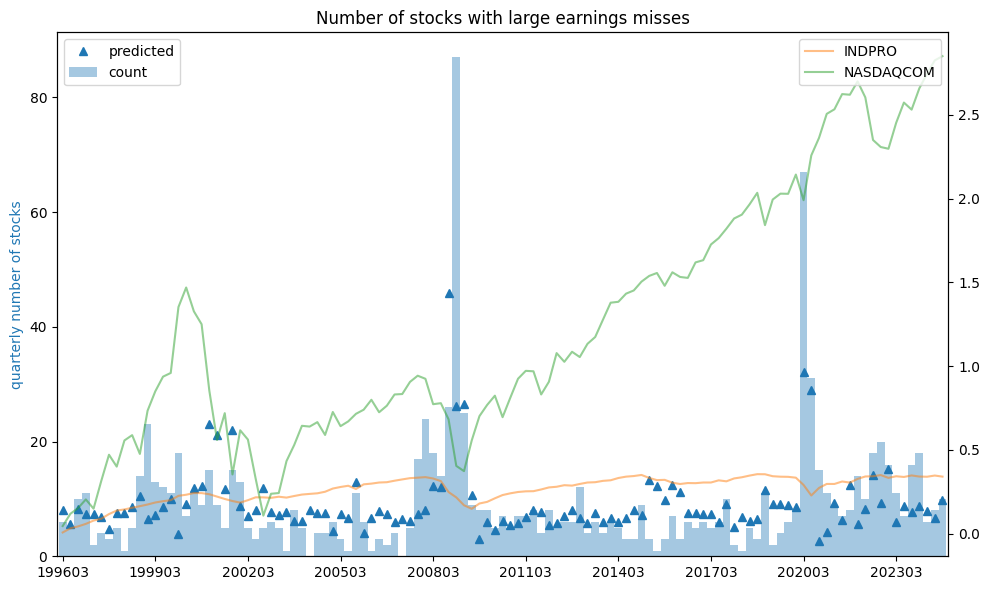

In [21]:
# Plot predicted and predictors
fig, ax = plt.subplots(figsize=(10, 6))
bx = ax.twinx()
Z['count'].plot(kind='bar', width=1.0, alpha=0.4, color="C0", ax=ax)
y_pred.plot(ls='', marker='^', color="C0", ax=ax)
ax.set_ylabel('quarterly number of stocks', color="C0")
Z['INDPRO'].cumsum().plot(color="C1", alpha=.5, ax=bx)
Z['NASDAQCOM'].cumsum().plot(color="C2", alpha=.5, ax=bx)
ax.legend(loc='upper left')
bx.legend(loc='upper right')
ax.set_xticks(np.arange(0, len(Z), 12), Z.index[::12])
ax.set_title('Number of stocks with large earnings misses')
plt.tight_layout()

__Credit losses__

Suppose a financial institution has a portfolio N loans, and:
- __default risk__ $p_i$ is the probability of default of the $i$ th loan
- __loss severity__ or loss given default $L_i$ is the portion of the $i$ th loan lost in the event of default.  This is often assumed known with certainty

Then Expected loss is the sum of Default Probability $\times$ Loss given default over all loans $= \sum_{i=1}^N p_i L_i$

The standard deviation of the expected loss on an individual loan, by applying the "Bernoulli shortcut" is $\sigma_i = \sqrt{p_i(1 - p_i)}L_i$.

The standard deviation of the loss of the portfolio depends on the correlation of defaults between loands $\sigma_P = \sqrt{\sum_i \sum_j \rho_{ij} \sigma_i \sigma_j}$. For tractability, the correlations may be simplified to be constant or determined by a (Gaussian) copula, though neither assumption suffices to model real markets.

__Actuarial Loss__:

- Severity

- Frequency


**References:**

https://sites.google.com/site/zoubin019/teaching/math-5639-actuarial-loss-models

Lim, Terence, 2001, "Rationality and Analysts' Forecast Bias", Journal of Finance, Volume 56, Issue 1, Pages 369-385. https://doi.org/10.1111/0022-1082.00329
